<h3>Does Twitter Mood Move Markets?<H3/>

*This project explores whether public sentiment on Twitter can explain short-term movements in the stock market. Using a dataset of 5,000 finance-related tweets (April–July 2020) and daily SPY prices from Yahoo Finance, we measure sentiment using the VADER model and test how it relates to daily returns.*

*We clean the data, compute sentiment scores, aggregate them by date, and compare them with SPY’s daily percentage changes. The goal is to evaluate whether shifts in online mood align with or predict market performance.*

In [107]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
import statsmodels.api as sm

In [4]:
# dataset source = https://www.kaggle.com/datasets/utkarshxy/stock-markettweets-lexicon-data?select=tweets_labelled_09042020_16072020.csv

tweets = pd.read_csv(r"C:\Users\HP\Desktop\tweets_new.csv", sep=None, engine="python")

In [5]:
# Shape of dataset (rows, columns)
print(tweets.shape)

# Column names
print(tweets.columns)

# Data types and missing values
print(tweets.info())

(5000, 4)
Index(['id', 'created_at', 'text', 'sentiment'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5000 non-null   int64 
 1   created_at  5000 non-null   object
 2   text        5000 non-null   object
 3   sentiment   1300 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB
None


In [6]:
print(tweets['text'].isna().sum())
print(tweets['text'].apply(lambda x: len(str(x))).describe())

0
count    5000.000000
mean      151.194000
std        66.973459
min         6.000000
25%       109.000000
50%       140.000000
75%       178.000000
max       344.000000
Name: text, dtype: float64


In [7]:
tweets.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive


We can see that our dataset has 5,000 rows and 4 columns: id, created_at, text, and sentiment, all entries have valid id, created_at, and text values, but only 1,300 out of 5,000 have a sentiment label. The created_at column contains timestamp strings, and the sentiment column includes categories like positive and negative.

In [9]:
# A little cleaning
tweets["Date"]=pd.to_datetime(tweets['created_at'])
tweets = tweets.set_index("Date")
tweets = tweets.drop(columns=['id', "created_at"])
tweets = tweets.sort_values('Date') # Making sure all dates are in a consistent format and sorted chronologically.

In [10]:
tweets.head()

,text,sentiment
Date,,
2020-04-09 00:00:03+00:00,"$HEXO target price is $2.21, HEXO has a upside...",positive
2020-04-09 00:20:44+00:00,You have the news: Disney+ Hits 50 Million Pai...,NaN
2020-04-09 01:02:35+00:00,RT @awallenstein: BREAKING: Disney+ reaches 50...,NaN
2020-04-09 01:11:26+00:00,RT @RichLightShed: With 50 million subs and gr...,NaN
2020-04-09 01:49:10+00:00,RT @thechartist: The $SPX recovering extremely...,NaN


In [11]:
def light_klin(text):
    text = re.sub(r"http\S+|www\S+", '', text)  # remove URLs
    text = re.sub(r'\s+', ' ', text).strip()    # normalize spaces
    return text

tweets['Text'] = tweets['text'].apply(light_klin)  
tweets = tweets.drop(columns=['text'])

In [12]:
tweets.head()

,sentiment,Text
Date,,
2020-04-09 00:00:03+00:00,positive,"$HEXO target price is $2.21, HEXO has a upside..."
2020-04-09 00:20:44+00:00,NaN,You have the news: Disney+ Hits 50 Million Pai...
2020-04-09 01:02:35+00:00,NaN,RT @awallenstein: BREAKING: Disney+ reaches 50...
2020-04-09 01:11:26+00:00,NaN,RT @RichLightShed: With 50 million subs and gr...
2020-04-09 01:49:10+00:00,NaN,RT @thechartist: The $SPX recovering extremely...


In [13]:
print(tweets['sentiment'].value_counts())

sentiment
positive    528
neutral     424
negative    348
Name: count, dtype: int64


In [14]:
tweets.head()

,sentiment,Text
Date,,
2020-04-09 00:00:03+00:00,positive,"$HEXO target price is $2.21, HEXO has a upside..."
2020-04-09 00:20:44+00:00,NaN,You have the news: Disney+ Hits 50 Million Pai...
2020-04-09 01:02:35+00:00,NaN,RT @awallenstein: BREAKING: Disney+ reaches 50...
2020-04-09 01:11:26+00:00,NaN,RT @RichLightShed: With 50 million subs and gr...
2020-04-09 01:49:10+00:00,NaN,RT @thechartist: The $SPX recovering extremely...


Right now, about 74% of our dataset has missing sentiment labels (NaN). Instead of deleting those rows, we can automatically predict sentiment for each unlabeled tweet using the pretrained rule-based sentiment analyzer VADER (Valence Aware Dictionary for sEntiment Reasoning).

Using VADER (Valence Aware Dictionary and sEntiment Reasoner) is a solid approach for filling in missing sentiment labels especially when the text data comes from social media like tweets. It’s specifically tuned for short, informal text containing emojis, slang, or punctuation emphasis

VADER assigns four sentiment scores to each text, positive, neutral, negative, and a compound score. The compound score (ranging from -1 to +1) represents the overall sentiment. we can use this value to classify the tweet sentiment.

In [17]:
analyzer = SentimentIntensityAnalyzer()

# Define function to get sentiment label
def vaderizer(Text):
    score = analyzer.polarity_scores(str(Text))['compound']
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Fill missing sentiment labels using VADER
tweets['Sentiment'] = tweets['sentiment'].fillna(tweets['Text'].apply(vaderizer))
tweets = tweets.drop(columns ="sentiment" )

In [18]:
tweets.head()

,Text,Sentiment
Date,,
2020-04-09 00:00:03+00:00,"$HEXO target price is $2.21, HEXO has a upside...",positive
2020-04-09 00:20:44+00:00,You have the news: Disney+ Hits 50 Million Pai...,neutral
2020-04-09 01:02:35+00:00,RT @awallenstein: BREAKING: Disney+ reaches 50...,positive
2020-04-09 01:11:26+00:00,RT @RichLightShed: With 50 million subs and gr...,positive
2020-04-09 01:49:10+00:00,RT @thechartist: The $SPX recovering extremely...,positive


In [19]:
# inspecting again
print(tweets['Sentiment'].value_counts())
print(tweets[['Text','Sentiment']].sample(10))

Sentiment
positive    2226
neutral     1784
negative     990
Name: count, dtype: int64
                                                                        Text  \
Date                                                                           
2020-07-03 09:05:46+00:00  Want to know more our #trading algorithms perf...   
2020-06-15 23:16:06+00:00  $FB facebook still hold its 220 support plus w...   
2020-06-24 08:25:30+00:00  Elliott Wave View: Facebook Should See More Up...   
2020-04-25 22:00:25+00:00  RT @syinvesting: #COVID19 Good @Reuters specia...   
2020-06-15 01:30:38+00:00  RT @futurestrader26: Time and acceptance betwe...   
2020-06-11 11:00:38+00:00  RT @LanceRoberts: Great point from @SoberLook ...   
2020-06-21 22:49:05+00:00  Grand Canyon Education Inc $LOPE Short Interes...   
2020-06-19 18:10:39+00:00  @zerohedge Some point soon this class of “inve...   
2020-07-13 09:36:40+00:00  RT @ETFProfessor: Nasdaq trading volume has sh...   
2020-06-24 20:55:22+00:00  Master

In [20]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2020-04-09 00:00:03+00:00 to 2020-07-16 23:33:55+00:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5000 non-null   object
 1   Sentiment  5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


Our dataset looks excellent, all 5,000 tweets have valid text and sentiment values, meaning no missing data issues remain. The datetime index is properly formatted, which makes it easy to group and analyze sentiment trends over time. So now lets go into aggregating daily sentiment to reveal how market mood fluctuates day by day.

We’ll assign numerical values to sentiment and then compute a daily mean.
+ Positive - +1
+ Neutral - 0
+ Negative - −1

In [22]:
# Map sentiment to numbers
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
tweets['Sentiment_score'] = tweets['Sentiment'].map(sentiment_map)

# Aggregate by date
daily_sentiment = tweets.resample('D').mean(numeric_only=True)

# Optional: drop days with no tweets
daily_sentiment = daily_sentiment.dropna()

In [23]:
daily_sentiment.head(10)
# daily_sentiment.tail(10)

,Sentiment_score
Date,
2020-04-09 00:00:00+00:00,0.140845
2020-04-10 00:00:00+00:00,0.322581
2020-04-11 00:00:00+00:00,0.105263
2020-04-12 00:00:00+00:00,0.323529
2020-04-13 00:00:00+00:00,0.114286
2020-04-14 00:00:00+00:00,0.147727
2020-04-15 00:00:00+00:00,0.136842
2020-04-16 00:00:00+00:00,0.500000
2020-04-17 00:00:00+00:00,0.219048


In [24]:
daily_sentiment['Sentiment_score'].describe()

count    77.000000
mean      0.245387
std       0.117557
min      -0.034483
25%       0.159420
50%       0.250000
75%       0.323944
max       0.500000
Name: Sentiment_score, dtype: float64

Notice that the daily sentiment scores are predominantly positive, indicating that tweets during this period(April 2020 - July 2020) generally expressed optimism about the market or the selected stocks due to major market rebounds post-COVID crash. This may reflect an overall bullish tone among users, or probably VADER’s limitations, since it was not developed for financial corpora. As posited by (Barik & Misra), ‘Because VADER was originally calibrated for social-media text rather than financial corpora, one should interpret its output with caution when applying it to market-related tweets.’

<Axes: ylabel='Density'>

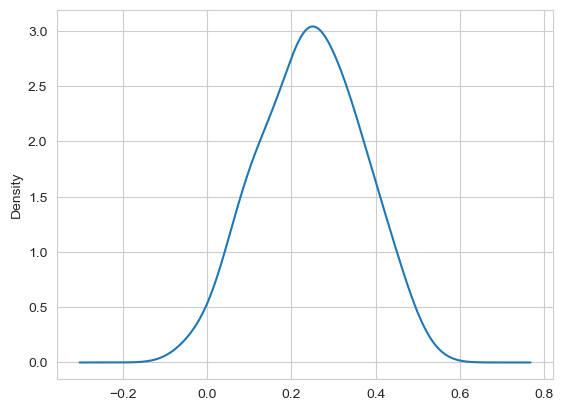

In [26]:
# visualizing
daily_sentiment['Sentiment_score'].plot(kind='kde')

In [27]:
# saving file
Sentiment = daily_sentiment.to_csv("daily_sentiment.csv", index=True)

Alright since our daily sentiment values are ready (even if mostly positive), the next step is getting stock data here we want to align real market performance with our sentiment timeline so we can test correlation or lag effects, we’ll use yfinance, which provides historical stock prices directly from Yahoo Finance.

We can figure out which stock (or topic) our tweet dataset is mostly about by doing a quick keyword frequency check on the text column. This will tell us which company tickers or names appear most often.

In [29]:
# Combine all tweets into one string
all_text = " ".join(tweets['Text'].astype(str)).lower()

# Find potential stock tickers (e.g., $AAPL, $TSLA)
tickers = re.findall(r'\$[A-Za-z]{1,5}', all_text)

# Count frequency of each ticker
Counter(tickers).most_common(10)

[('$spx', 938),
 ('$spy', 655),
 ('$aapl', 641),
 ('$amzn', 561),
 ('$fb', 479),
 ('$tsla', 360),
 ('$msft', 330),
 ('$es', 252),
 ('$qqq', 247),
 ('$nflx', 201)]

Our tweets dataset mostly reference SPX and SPY, meaning they reflect genera; market sentiment, so now using SPY as our stock ticker makes the most sense, since it tracks the S&P 500’s daily movement and at per with our tweet themes.

In [62]:
# Download daily price data for SPY
stock = yf.download('SPY', start='2020-04-01', end='2020-07-31')

stock = stock[['Close']]# Keep only closing prices

C:\Users\HP\AppData\Local\Temp\ipykernel_3516\2145699259.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download('SPY', start='2020-04-01', end='2020-07-31')
[*********************100%***********************]  1 of 1 completed


In [64]:
stock.head()

Price,Close
Ticker,SPY
Date,
2020-04-01,227.559692
2020-04-02,232.810699
2020-04-03,229.445572
2020-04-06,244.856598
2020-04-07,245.106247


In [66]:
stock.columns = stock.columns.get_level_values(0)

In [72]:
stock.head()

Price,Close
Date,
2020-04-01,227.559692
2020-04-02,232.810699
2020-04-03,229.445572
2020-04-06,244.856598
2020-04-07,245.106247


We have to note that missing dates are normal since weekends and market holidays aren’t included, so therefore oour daily sentiment aggregation will have to ignore weekend sentiment spikes


Let us compute daily returns so we can convert prices into percentage changes and analyze how sentiment might relate to market movements.

In [76]:
stock['Daily_return'] = stock['Close'].pct_change()

stock.head()

Price,Close,Daily_return
Date,,
2020-04-01,227.559692,NaN
2020-04-02,232.810699,0.023075
2020-04-03,229.445572,-0.014454
2020-04-06,244.856598,0.067166
2020-04-07,245.106247,0.001020


The next step is to merge our daily sentiment scores with these stock returns, this is meant to give us one clean dataset where each trading day has an average sentiment score, Tweet volume, SPY closing price, Daily return

In [80]:
# Aligning Timezones
# Remove timezone info from the sentiment index
daily_sentiment.index = daily_sentiment.index.tz_localize(None)

# Confirm same format
stock.index = pd.to_datetime(stock.index)

In [82]:
# Merging
Sentiment_merged= daily_sentiment.merge(stock[['Daily_return']], left_index=True, right_index=True, how='inner')

In [84]:
# Inspect merged dataset
Sentiment_merged.head()

,Sentiment_score,Daily_return
Date,,
2020-04-09,0.140845,0.015217
2020-04-13,0.114286,-0.009130
2020-04-14,0.147727,0.029493
2020-04-15,0.136842,-0.021248
2020-04-16,0.500000,0.004824


Yes, weekends were ignored because the stock market is closed on those days, so no returns exist to match them, the inner merge kept only the overlapping dates meaning trading days with both sentiment and return data, this is correct for analyzing same-day effects, since comparing weekend tweets to nonexistent market movements wouldn’t make sense (Johnson).

In [96]:
print(Sentiment_merged.info())
print(Sentiment_merged.shape)
print(Sentiment_merged.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53 entries, 2020-04-09 to 2020-07-16
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sentiment_score  53 non-null     float64
 1   Daily_return     53 non-null     float64
dtypes: float64(2)
memory usage: 1.2 KB
None
(53, 2)
       Sentiment_score  Daily_return
count        53.000000     53.000000
mean          0.243959      0.002940
std           0.113287      0.015851
min          -0.034483     -0.057649
25%           0.163043     -0.005580
50%           0.242857      0.005507
75%           0.323944      0.012959
max           0.500000      0.029493


So far we have extracted daily sentiment scores from tweets, pulled SPY daily prices from Yahoo Finance, calculated daily returns, merged both datasets cleanly on matching dates (trading days).


Now we are ready for visualization and correlation, let us first explore the relationship and test whether sentiment predicts market movement.

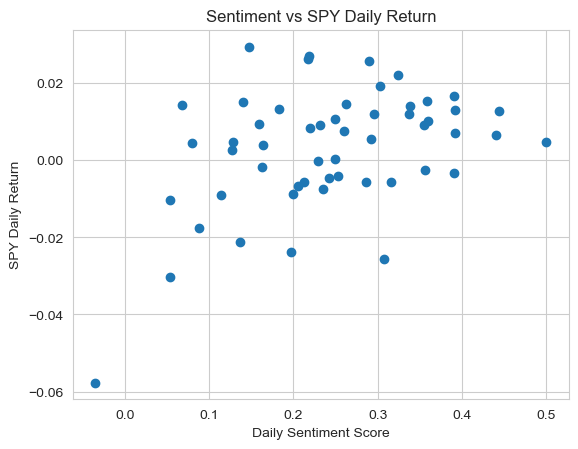

In [100]:
plt.scatter(Sentiment_merged['Sentiment_score'], Sentiment_merged['Daily_return'])
plt.xlabel('Daily Sentiment Score')
plt.ylabel('SPY Daily Return')
plt.title('Sentiment vs SPY Daily Return')
plt.show()

The scatter plot shows a weak positive relationship between daily sentiment scores and SPY daily returns, it shows that as sentiment increases, returns slightly tend to rise, but the points are widely scattered probably suggesting that sentiment alone has limited predictive power for short-term returns.

To confirm whether that faint upward tilt is real or just noise, the next step is quantifying it by testing the correlation

In [105]:
Sentiment_merged['Sentiment_score'].corr(Sentiment_merged['Daily_return'])

0.41982592599424945

A correlation of 0.42 suggests a moderate positive relationship between sentiment and SPY returns. When sentiment rises, returns tend to increase, though not perfectly. 


Let us test further with a simple regression to confirm significance.

In [111]:
X = sm.add_constant(Sentiment_merged['Sentiment_score'])
y = Sentiment_merged['Daily_return']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit() #Fit OLS model

In [113]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Daily_return   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     10.91
Date:                Sun, 02 Nov 2025   Prob (F-statistic):            0.00175
Time:                        11:36:43   Log-Likelihood:                 150.10
No. Observations:                  53   AIC:                            -296.2
Df Residuals:                      51   BIC:                            -292.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0114      0.005     

Explanation:
+ R-squared = 0.176: This means about 17.6% of the variation in SPY’s daily returns can be explained by sentiment which is modest and it’s actually a decent signal.

+ Sentiment_score coefficient = 0.0587, p = 0.002:The relationship is positive and statistically significant saying that when sentiment rises by 1 unit, SPY’s daily return increases by roughly 0.0587 (≈5.9%), on average. The low p-value (<0.05) means this isn’t likely due to chance.

+ Intercept = -0.0114: When sentiment is zero, the average daily return is about -1.1%. So, neutral sentiment tends to coincide with small declines.

+ Residual stats (Durbin-Watson, JB, etc.):They look fine — no big signs of autocorrelation or non-normal errors, meaning the regression’s assumptions are roughly okay.

There’s a statistically significant positive link between tweet sentiment and SPY daily returns during our sample. In short: when the market chatter got more optimistic, SPY tended to rise slightly.


Next we do a *Scatter + Regression Line (Relationship View)*, we need a plot that shows how daily sentiment aligns with returns — same as our earlier scatter, but with a fitted OLS line overlayed.

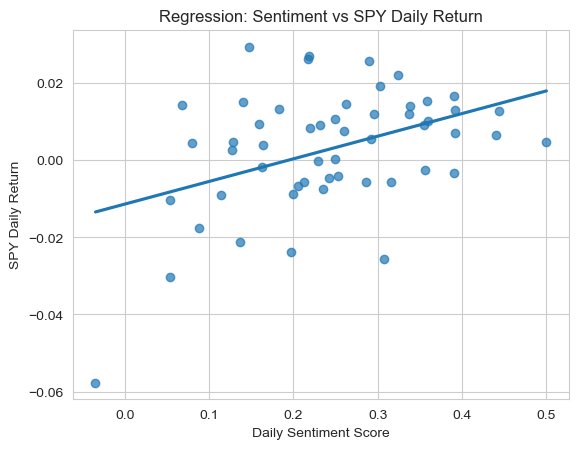

In [120]:
sns.regplot(x='Sentiment_score', y='Daily_return', data=Sentiment_merged, ci=None, scatter_kws={'alpha':0.7})
plt.title('Regression: Sentiment vs SPY Daily Return')
plt.xlabel('Daily Sentiment Score')
plt.ylabel('SPY Daily Return')
plt.show()

This plot (regression line) shows that as daily sentiment scores rise, SPY daily returns also tend to increase slightly, a mild but noticeable positive trend. This supports the regression output where the coefficient for sentiment (≈ 0.0587) was positive and statistically significant.

Now lets do a Time series comparison, to helps check whether sentiment changes tend to precede or align with return changes.

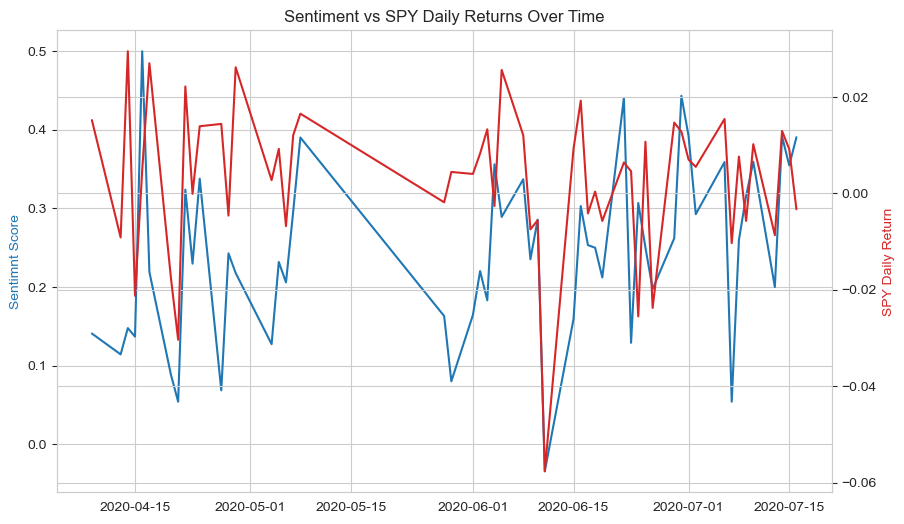

In [123]:
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(Sentiment_merged.index, Sentiment_merged['Sentiment_score'], color='tab:blue', label='Sentiment Score')
ax1.set_ylabel('Sentimnt Score', color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(Sentiment_merged.index, Sentiment_merged['Daily_return'], color='tab:red', label='SPY Daily Return')
ax2.set_ylabel('SPY Daily Return', color='tab:red')

plt.title('Sentiment vs SPY Daily Returns Over Time')
plt.show()

This time series plot adds context sentiment and returns move in the same general direction on several occasions, though not perfectly, this confirms markets may react to collective mood swings, but other factors (earnings, macro news, etc.) still dominate, we can confiently say that public mood nudges the market, but it doesn’t steer it entirely.

**Conclusion**

Our analysis of 5,000 finance-related tweets from April–July 2020 shows that positive sentiment on Twitter is modestly but significantly associated with higher SPY daily returns. The OLS model suggests sentiment explains roughly 17% of the variation in returns which indicated that social mood contributes, but does not dominate, market movements.

This aligns with behavioral finance ideas, notably emphasized by Robert J. Shiller, who argues that investor psychology and collective sentiment can drive short-term price fluctuations even in large, ostensibly efficient markets (Shiller). However, the influence is small and unstable, reminding us that markets are shaped more by fundamentals and macro events than by social chatter alone.

**Limitations & Future Work**

The analysis is limited by its small secondary dataset obtained from Kaggle and focuses only on a single stock index (SPY), which narrows the generalizability of the findings. Moreover, the VADER sentiment scoring approach may oversimplify the nuanced and often contradictory tone found in financial language, potentially missing subtleties like sarcasm or mixed sentiment within market discussions.

Future iterations of this study could incorporate lagged sentiment effects, examine multiple stocks across sectors, or distinguish between topic-specific sentiments such as earnings announcements, inflation news, or technology-related tweets.

Integrating news sentiment, trading volume, and volatility indicators could also enhance the predictive strength of the model and provide a more comprehensive understanding of how market psychology interacts with price movements.

Refernces

+ Barik, Kousik, and Sanjay Misra. “Analysis of Customer Reviews with an Improved VADER Lexicon Classifier.” *Journal of Big Data*, vol. 10, no. 1, 2023, p. 61. SpringerOpen, [Link](https://doi.org/10.1186/s40537-023-00861-x](https://doi.org/10.1186/s40537-023-00861-x).

+ Johnston, Matthew. “Which Days Are the U.S. Stock Exchanges Closed?” *Investopedia*, edited by Charlene Rhinehart, fact-checked by Kirsten Rohrs Schmitt, updated 26 Apr. 2025, [Link to site](https://www.investopedia.com/ask/answers/06/stockexchangeclosed.asp). Accessed 2 Nov. 2025.

+ Shiller, Robert J. Irrational Exuberance. Princeton University Press, 2000.

+ Zeus. *Stock Market Tweet, Sentiment Analysis Lexicon: Twitter Lexicon Data for #Stocks.* Kaggle, 2019, [Link to dataset](https://www.kaggle.com/datasets/utkarshxy/stock-markettweets-lexicon-data).